### This notebook contains codes relating to bounding boxes, keypoint detection, ball tracking and court detection

# Visualisations

In [43]:
import pandas as pd
df = pd.read_csv("COURT_CSV")
for idx, row in df.iterrows():
    video, frame, x1, y1, x2, y2, x3, y3, x4, y4 = row

    if idx == 100:
        break

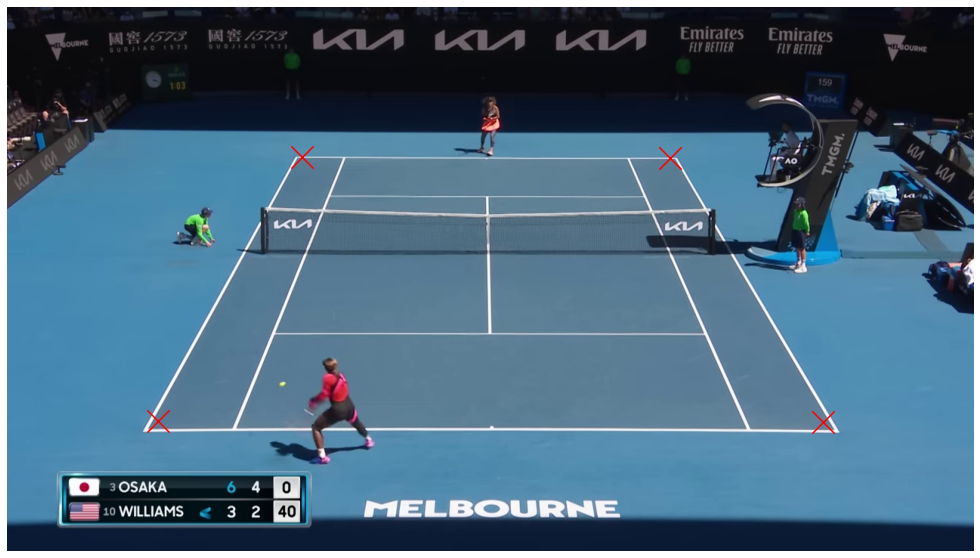

In [44]:
import matplotlib.pyplot as plt

img = plt.imread("FRAME_FILE")
pts = [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
pts = np.array(pts)
fig = plt.figure(figsize=(18, 10))
plt.imshow(img)
plt.axis('off')
plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=500)
plt.show()


In [8]:
import pandas as pd
import numpy as np
name = "RALLY_OF_INTEREST"
kp = pd.read_pickle("KEY_POINT_DIR" + name + ".pkl")
player1 = kp['keypoint'][0][154] # Replace 154 with frame number of interest
player2 = kp['keypoint'][1][154] # Replace 154 with frame number of interest
total = np.concatenate((player1, player2), axis=0)

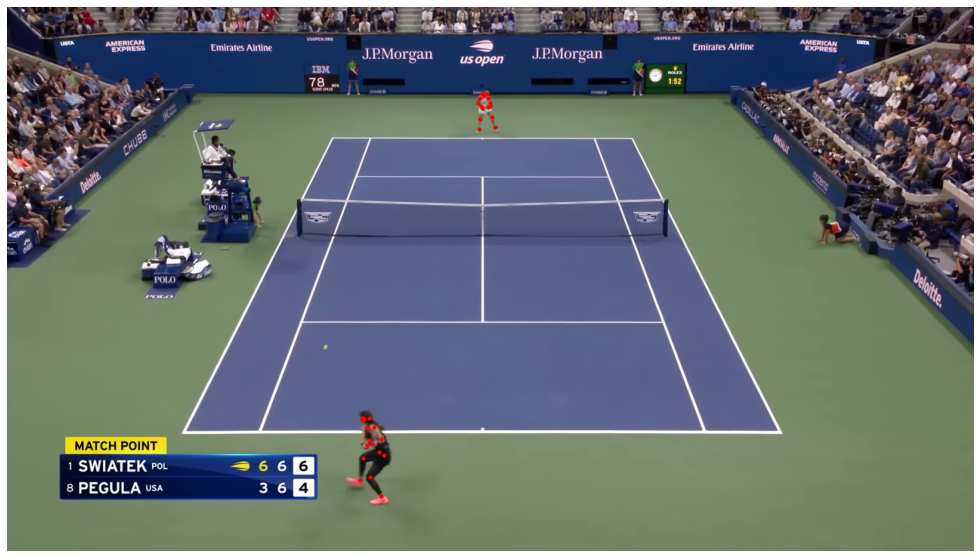

In [9]:
import matplotlib.pyplot as plt

img = plt.imread("IMG_FILE")
pts = total
fig = plt.figure(figsize=(18, 10))
plt.imshow(img)
plt.axis('off')
plt.scatter(pts[:, 0], pts[:, 1], marker="o", color="red", s=10)
plt.show()


# Drawing bounding boxes in video

In [2]:
import pandas as pd
import os
import cv2

In [3]:
def bbox(path, filename, start):
    content = pd.read_csv(path)
    video_name = filename + ".mp4"
    vid = ""
    output = ""
    if video_name in os.listdir("TRAIN_DIR"):
        vid = os.path.join("TRAIN_DIR/", video_name)
        output = os.path.join("OUTPUT_DIR/", video_name)
    elif video_name in os.listdir("TEST_DIR"):
        vid = os.path.join("TEST_DIR", video_name)
        output = os.path.join("TEST_OUTPUT_DIR", video_name)
    else:
        print(filename, " not found")
        return
    video = cv2.VideoCapture(vid)
    fps = int(video.get(cv2.CAP_PROP_FPS))
    length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output_video = cv2.VideoWriter(output, fourcc, fps, (width, height))
    
    frame_number = 0
    
    far_bbox = {}
    near_bbox = {}
    
    for bb in content.iterrows():
        far_bbox[bb[1]['frame'] - start] = [bb[1]['far_x1'], bb[1]['far_y1'], bb[1]['far_x2'], bb[1]['far_y2']]
        near_bbox[bb[1]['frame'] - start] = [bb[1]['near_x1'], bb[1]['near_y1'], bb[1]['near_x2'], bb[1]['near_y2']]
        
    frames = len(far_bbox)
    print(length, frames)
    
    while video.isOpened(): 
        ret, frame = video.read()
        if not ret:
            break  # Exit if no more frames

        # Draw each bounding box on the frame
        temp_frame = max(int(round(frame_number / length * frames, 0)), 0 )
        
        color = (255, 255, 0)  # Yellow
        thickness = 3  # Thickness of the bounding box
        if temp_frame in far_bbox and far_bbox[temp_frame][0] != -1:
            cv2.rectangle(frame, (far_bbox[temp_frame][0], far_bbox[temp_frame][1]), (far_bbox[temp_frame][2], far_bbox[temp_frame][3]), color, thickness)
        if temp_frame in near_bbox and near_bbox[temp_frame][0] != -1:
            cv2.rectangle(frame, (near_bbox[temp_frame][0], near_bbox[temp_frame][1]), (near_bbox[temp_frame][2], near_bbox[temp_frame][3]), color, thickness)

        # Write the frame with bounding boxes to the output video
        output_video.write(frame)

        frame_number += 1

In [ ]:
err = 0
done = 0
t_dir = "BBOX_DIR"
for f in os.listdir(t_dir):
    name = ''.join(f.split('.')[:-1])
    start = name.split('_')[-2]
    try:
        bbox(os.path.join(t_dir, f), name, int(start))
        done += 1
    except:
        print(name, " gave an error")
        err += 1

print(done, " files done.")
print(err, " files gave an error.")

# Prepare dataset with model's information

In [45]:
import os
def write_to_dict(cls, name,frames):
    # Current code passes 4 keypoints - arms, legs
    to_write = {}
    to_write['id'] = len(all_json)
    to_write['video'] = name + ".mp4"
    
    keypoints = f"KEY_POINT_DIR" + name + ".pkl"
    
    keypoints = pd.read_pickle(keypoints)['keypoint']
    
    first_keypoint = []
    second_keypoint = []
    
    
    for kp in keypoints[0]:
        first_keypoint.append([kp[4], kp[7], kp[10], kp[13]])
    for kp in keypoints[1]:
        second_keypoint.append([kp[4], kp[7], kp[10], kp[13]])
        
    bball = pd.read_pickle("C:/Users/charlton/Downloads/balls-20250208T061248Z-001/balls/" + name + ".pickle")
    ball = []
    for b in bball:
        if len(b['ball_centers']) > 0:
            ball.append(list(b['ball_centers'][0]))
    
    
    df = pd.read_csv("C:/Users/charlton/Downloads/court-20250208T061247Z-001/court/" + name + ".csv")
    start = int(name.split("_")[-2])
    end = int(name.split("_")[-1])
    
    court = []
    
    for idx, row in df.iterrows():
        if idx == 0:
            pvideo, pframe, px1, py1, px2, py2, px3, py3, px4, py4 = row
            court.append([px1, py1, px2, py2, px3, py3, px4, py4])
            continue
        else:
            video, frame, x1, y1, x2, y2, x3, y3, x4, y4 = row
            while start != frame and start != end:
                court.append([px1, py1, px2, py2, px3, py3, px4, py4])
                start+=1
            px1, py1, px2, py2, px3, py3, px4, py4 = x1, y1, x2, y2, x3, y3, x4, y4
        

        
    first_keypoint = first_keypoint[::5]
    court = court[::5]
    ball = ball[::5]
    second_keypoint = second_keypoint[::5]
    reply = ""
    for idx, cl in enumerate(cls):
        nf, fbh, rss, shot, il = cl.split('_')
        il = " " + il
        shot = '' if shot == '-' else " " + shot
        fbh = '' if fbh == '-' else " " + fbh
        reply += f"The {nf} player hit a{fbh}{shot} {rss}{il}. "
    if not os.path.isfile('D:/fyp/track_train_videos/'+ to_write['video']):
        return
    value = f"<video>\nGiven this the far player's key points in each frame in format (x1, y1): {first_keypoint}, and the near player's key points in each frame in format (x1, y1): {second_keypoint}, and the tennis ball's coordinates in format [x, y]: {ball}, \
        and given the following court dimensions in the form of [x1, y1, x2, y2, x3, y3, x4, y4]: {court}, describe the tennis actions in the video."
    value = value.replace("array", "")
    value = value.replace("\n      ", "")
    to_write['conversations'] = [
    {
        "from": "human", 
        "value": value
    },
    {
        "from": "gpt",
        "value": reply
    }]
    
    for i in mappings:
        to_write['conversations'][1]["value"] = to_write['conversations'][1]["value"].replace(i, mappings[i])
    all_json.append(to_write)

In [ ]:
for index, row in train.iterrows():
    if not os.path.exists(f'D:\\fyp\\track_train_videos\\{row["video"]}.mp4'):
        continue
    try:
        events = row['events']
        name = row['video']
        print(name)
        labels = []
        frames = []
        for event in events:
            label = event['label']
            labels.append(label)
            frames.append(event['frame'])
        write_to_dict(labels, name, frames) 
    except:
        continue

print(all_json[5])

In [ ]:
import json

with open(f'./track_labels_2.json', 'w', encoding='utf-8') as f:
    json.dump(all_json, f, ensure_ascii=False, indent=4)


In [46]:
import pandas as pd
test = pd.read_json('test.json')
test

,events,fps,height,width,num_frames,video,ply1_name,ply2_name,ply1_hand,ply2_hand,ply1_set,ply2_set,ply1_game,ply2_game,ply1_point,ply2_point
0,"[{'frame': 73, 'label': 'far_-_serve_B_in'}, {...",29,720,1280,410,20210909-W-US_Open-SF-Emma_Raducanu-Maria_Sakk...,Emma Raducanu,Maria Sakkari,RH,RH,0,0,0,0,0,1
1,"[{'frame': 50, 'label': 'far_-_serve_-_last'}]",29,720,1280,195,20210909-W-US_Open-SF-Emma_Raducanu-Maria_Sakk...,Emma Raducanu,Maria Sakkari,RH,RH,0,0,0,0,0,2
2,"[{'frame': 50, 'label': 'far_-_serve_W_in'}, {...",29,720,1280,279,20210909-W-US_Open-SF-Emma_Raducanu-Maria_Sakk...,Emma Raducanu,Maria Sakkari,RH,RH,0,0,0,0,1,3
3,"[{'frame': 93, 'label': 'far_-_serve_T_in'}, {...",29,720,1280,272,20210909-W-US_Open-SF-Emma_Raducanu-Maria_Sakk...,Emma Raducanu,Maria Sakkari,RH,RH,0,0,0,0,2,3
4,"[{'frame': 50, 'label': 'far_-_serve_-_last'}]",29,720,1280,164,20210909-W-US_Open-SF-Emma_Raducanu-Maria_Sakk...,Emma Raducanu,Maria Sakkari,RH,RH,0,0,0,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266,"[{'frame': 33, 'label': 'far_-_serve_W_in'}, {...",25,720,1280,120,20230125-W-Australian_Open-QF-Magda_Linette-Ka...,Karolina Pliskova,Magda Linette,RH,RH,0,1,5,5,0,1
2267,"[{'frame': 50, 'label': 'far_-_serve_W_in'}, {...",25,720,1280,203,20230125-W-Australian_Open-QF-Magda_Linette-Ka...,Karolina Pliskova,Magda Linette,RH,RH,0,1,5,6,1,0
2268,"[{'frame': 27, 'label': 'far_-_serve_W_in'}, {...",25,720,1280,149,20230125-W-Australian_Open-QF-Magda_Linette-Ka...,Karolina Pliskova,Magda Linette,RH,RH,0,1,5,6,1,1
2269,"[{'frame': 10, 'label': 'far_-_serve_W_in'}, {...",25,720,1280,139,20230125-W-Australian_Open-QF-Magda_Linette-Ka...,Karolina Pliskova,Magda Linette,RH,RH,0,1,5,6,1,2


In [48]:
all_list = ""

mappings = {'fh': 'forehand',
           'bh': 'backhand',
           'CC': 'cross-court',
           'DL': 'down the line',
           'DM': 'down the middle',
           'IO': 'inside out',
           'II': 'inside in',
           ' W ': ' wide ',
           ' B ': ' body '
           }

In [ ]:
import os
for index, row in test.iterrows():
    if not os.path.exists(f'D:\\fyp\\track_test_videos\\{row["video"]}.mp4'):
        continue
    events = row['events']
    name = row['video']
    
    keypoints = f"D:\\fyp\\f3set-tennis-20250226T093655Z-001\\f3set-tennis\\" + name + ".pkl"
    bball = pd.read_pickle("C:/Users/charlton/Downloads/balls-20250208T061248Z-001/balls/" + name + ".pickle")
    ball = []
    for b in bball:
        if len(b['ball_centers']) > 0:
            ball.append(list(b['ball_centers'][0]))
    
    keypoints = pd.read_pickle(keypoints)['keypoint']
    
    first_keypoint = []
    second_keypoint = []
    
    
    for kp in keypoints[0]:
        first_keypoint.append([kp[4], kp[7], kp[10], kp[13]])
    for kp in keypoints[1]:
        second_keypoint.append([kp[4], kp[7], kp[10], kp[13]])

        
    bball = pd.read_pickle("C:/Users/charlton/Downloads/balls-20250208T061248Z-001/balls/" + name + ".pickle")
    ball = []
    for b in bball:
        if len(b['ball_centers']) > 0:
            ball.append(list(b['ball_centers'][0]))
    
    
    df = pd.read_csv("C:/Users/charlton/Downloads/court-20250208T061247Z-001/court/" + name + ".csv")
    start = int(name.split("_")[-2])
    end = int(name.split("_")[-1])
    
    court = []
    
    for idx, row in df.iterrows():
        if idx == 0:
            pvideo, pframe, px1, py1, px2, py2, px3, py3, px4, py4 = row
            court.append([px1, py1, px2, py2, px3, py3, px4, py4])
            continue
        else:
            video, frame, x1, y1, x2, y2, x3, y3, x4, y4 = row
            while start != frame and start != end:
                court.append([px1, py1, px2, py2, px3, py3, px4, py4])
                start+=1
            px1, py1, px2, py2, px3, py3, px4, py4 = x1, y1, x2, y2, x3, y3, x4, y4
        

        
    first_keypoint = first_keypoint[::5]
    court = court[::5]
    ball = ball[::5]
    second_keypoint = second_keypoint[::5]
    
    value = f"{name} : Given this list of the far player's key point in each frame in format (x1, y1): {first_keypoint}, and this list of the near player's key point in each frame in format (x1, y1): {second_keypoint}, and this list of the tennis ball's coordinates in format [x, y]: {ball}, \
        and given the following court dimensions in the form of [x1, y1, x2, y2, x3, y3, x4, y4]: {court}, describe the tennis actions in the video.\n"
    value = value.replace("array", "")
    value = value.replace("\n      ", "")
        
    all_list += value
    


In [ ]:
with open('track_test_3.txt', 'w') as f:
    f.write(all_list)